# Multimapping analysis 
## Before running this notebook:
1. Ran `analysis2_multipmapping.sh` to generate lookup tables for all bam files 
2. Pick reads of interest: 
bed file: `data/full_intergenic.bed`
bam files:
- `analysis/longread_files/SGNex_MCF7_directcDNA_replicate1_run2/SGNex_MCF7_directcDNA_replicate1_run2.bam`
- `analysis/longread_files/SGNex_MCF7_directcDNA_replicate3_run3/SGNex_MCF7_directcDNA_replicate3_run3.bam`
- `analysis/longread_files/SGNex_MCF7_directcDNA_replicate4_run2/SGNex_MCF7_directcDNA_replicate4_run2.bam`
- `analysis/illumina_files/SGNex_MCF7_Illumina_replicate2_run1/SGNex_MCF7_Illumina_replicate2_run1.bam`
- `analysis/illumina_files/SGNex_MCF7_Illumina_replicate3_run1/SGNex_MCF7_Illumina_replicate3_run1.bam`
- `analysis/illumina_files/SGNex_MCF7_Illumina_replicate4_run1/SGNex_MCF7_Illumina_replicate4_run1.bam`
Focusing on 
- `longread_files/SGNex_MCF7_directcDNA_replicate3_run3/SGNex_MCF7_directcDNA_replicate3_run3.bam`
- `illumina_files/SGNex_MCF7_Illumina_replicate3_run1/SGNex_MCF7_Illumina_replicate3_run1.bam`
Command: 
```
sed 's/^chr//' data/full_intergenic.bed > data/full_intergenic_no_chr.bed
bedtools intersect -abam longread_files/SGNex_MCF7_directcDNA_replicate3_run3/SGNex_MCF7_directcDNA_replicate3_run3.bam -b data/full_intergenic_no_chr.bed -bed | awk '{print $4}' > read_ids.txt


bedtools intersect -abam illumina_files/SGNex_MCF7_Illumina_replicate3_run1/SGNex_MCF7_Illumina_replicate3_run1.bam -b data/full_intergenic_no_chr.bed -bed | awk '{print $4}' > illumina_files/SGNex_MCF7_Illumina_replicate3_run1/read_ids.txt
```

awk '{print $4}'
awk '{print substr($4, 1, length($4)-2)}'

In [ ]:
# What do I need to do:
# 1. Figure out if I can just use the first value in the lookup table (I think I can)
# 2. Figure out how to rerun the lookup table code so it just prints one copy of all of the reads

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def run_sims(df, read_ids, title, n_iterations=1000):
    l1hs_df = df[df["read_id"].isin(read_ids)]
    # Create a background distribution by random sampling
    sample_size = len(l1hs_df)
    background_distributions = []

    for _ in range(n_iterations):
        sample = df.sample(n=sample_size)
        background_distributions.append(sample["count"].mean())

    l1hs_mean = l1hs_df["count"].mean()
    p_value = stats.ttest_1samp(background_distributions, l1hs_mean).pvalue

    # Print the result
    print(f"L1HS Mean: {l1hs_mean}, P-value: {p_value}")

    # Jitter plot
    plt.figure(figsize=(10, 6))
    sns.stripplot(data=[background_distributions, l1hs_df["count"]], jitter=True)
    plt.title(f"Jitter Plot of Background Distribution and L1HS Reads for {title}")
    plt.ylabel("Read Count")
    plt.xticks([0, 1], ["Background", "L1HS"])
    plt.show()

In [2]:
df = pd.read_csv(
    "longread_files/SGNex_MCF7_directcDNA_replicate3_run3/SGNex_MCF7_directcDNA_replicate3_run3_lookup_table.txt",
    sep="\t",
    header=None,
).drop_duplicates(subset=0, keep="first")
df.columns = ["read_id", "count"]

In [3]:
df

,read_id,count
0,00000a21-7076-4538-9613-da3bb8fa2c08,1
1,00000abb-0179-4fb6-a230-b33825cfbe63,1
2,00000c88-e142-4000-abc3-6c5a45a421b5,3
5,00001674-85db-43a1-a402-25ad5280371d,1
6,00001700-5faf-4c42-9618-a0a23e81987b,1
...,...,...
2951938,ffffd4ab-f645-4a70-9e65-8a49d9e6bef2,1
2951940,ffffd8e2-c604-4b1a-a532-455b242ee212,1
2951941,ffffda83-ecb1-4cca-ba75-38cda94984de,1
2951944,fffff58c-8f70-41bd-94c5-7813c8b0a368,1


In [7]:
# Read the file and store each line as an element in a list
with open(
    "longread_files/SGNex_MCF7_directcDNA_replicate3_run3/reads_id.txt", "r"
) as file:
    read_ids = file.readlines()
read_ids = list(set([line.strip() for line in read_ids]))

In [15]:
l1hs_df = df[df["read_id"].isin(read_ids)].sort_values(by="count", ascending=False)
l1hs_df

,read_id,count
521949,2d3f53f5-829b-4aa1-808f-6b38568e9172,4
62973,0576be76-7058-4cc3-a035-be04a130ea79,3
2511645,d9c8f8d3-95aa-4c8f-930a-053ec8cd507c,3
285405,18c3032b-953b-47be-957a-a52d3eec7695,3
1267661,6de90fe3-a607-44d3-aec2-9310c9f57dd9,3
...,...,...
934268,510ea157-fabc-461a-be58-22e4db5b9b9f,1
929808,50aa70da-aa37-4dad-a941-16a8490eddcb,1
926743,50699ecc-cc54-4da4-9c77-20e2e6f6bad2,1
926496,50651267-7a45-4a02-ae72-2e8f4a8e3c7b,1


L1HS Mean: 1.103658536585366, P-value: 0.0


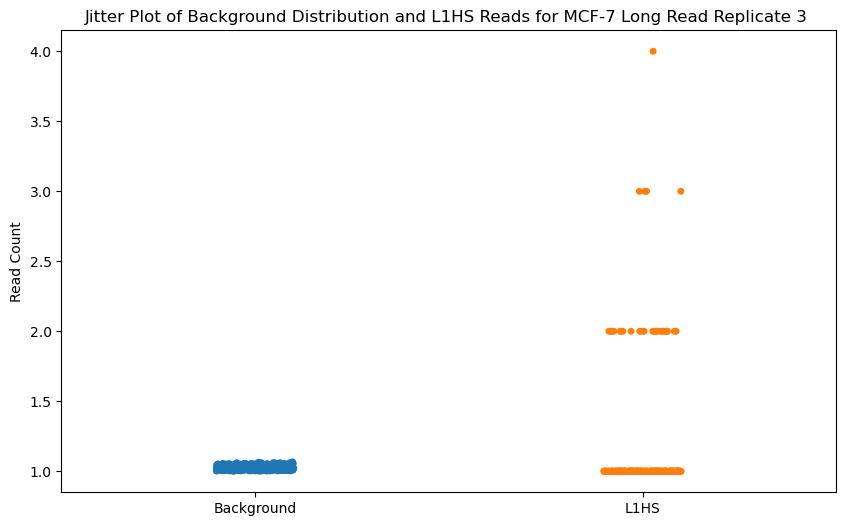

In [25]:
run_sims(df, read_ids, "MCF-7 Long Read Replicate 3")

In [3]:
df = pd.read_csv(
    "illumina_files/SGNex_MCF7_Illumina_replicate3_run1/SGNex_MCF7_Illumina_replicate3_run1_lookup_table.txt",
    sep="\t",
    header=None,
).drop_duplicates(subset=0, keep="first")
df.columns = ["read_id", "count"]

# Read the file and store each line as an element in a list
with open(
    "illumina_files/SGNex_MCF7_Illumina_replicate3_run1/read_ids.txt", "r"
) as file:
    read_ids = file.readlines()
read_ids = list(set([line.strip()[:-2] for line in read_ids]))

In [4]:
df[df["read_id"].isin(read_ids)].sort_values(by="count", ascending=False)

,read_id,count
6339158,K00151:464:H3HL2BBXY:2:1218:4482:30081,32
28804593,K00151:464:H3HL2BBXY:3:2214:7405:31136,22
13377150,K00151:464:H3HL2BBXY:2:2214:13484:40051,22
2822340,K00151:464:H3HL2BBXY:2:1121:11546:16964,20
29706533,K00151:464:H3HL2BBXY:3:2221:25073:12304,20
...,...,...
13965020,K00151:464:H3HL2BBXY:2:2218:21176:38539,2
14039516,K00151:464:H3HL2BBXY:2:2218:8389:43814,2
14056663,K00151:464:H3HL2BBXY:2:2219:12347:46170,2
14138846,K00151:464:H3HL2BBXY:2:2219:29477:2352,2


In [5]:
run_sims(df, read_ids, "MCF-7 Short Read Replicate 3")